# Visualization

Import modules and packages

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

import gc
gc.collect()

import cv2
import time
import random
import natsort
from pathlib import Path

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["axes.grid"]=False

# Import pytorch modules
import torch
torch.cuda.empty_cache()

import dlib
from imutils import face_utils
import torchvision.transforms.functional as TF

# Import local modules
from src.models.xception import *
from src.utils.get_list import *
from src.utils.print_overwrite import *

device = 'cuda:3' if torch.cuda.is_available() else 'cpu'

SRC_ROOT = "/home/ubuntu/workspace/FLD-scratch/src/"

INPUT_ROOT = "/data/komedi/k-face-100"
IMAGE_ROOT = os.path.join(INPUT_ROOT, "cropped_img")
IMAGE_LIST = get_file_list(IMAGE_ROOT, case="image")

pretrained_model = '/home/ubuntu/workspace/FLD-scratch/src/pretrained_model/xcep_27pt_100epoch_drop07.pt'
model_name = Path(pretrained_model).stem
model = XceptionNet(num_classes=54)
model.eval()

if pretrained_model:
    state_dict = torch.load(pretrained_model,map_location='cpu')
    model.load_state_dict(state_dict)

model = model.to(device)

print(model.load_state_dict(state_dict))


<All keys matched successfully>


Set function

In [2]:
def preprocess_image(image):
    image = TF.to_pil_image(image) # to PIL format
    image = TF.resize(image, (128, 128)) # resize
    image = TF.to_tensor(image) # to tensor
    return image.unsqueeze(0)

def draw_landmarks_on_faces(image, faces_landmarks):
    image = image.copy()
    for landmarks, (left, top, height, width) in faces_landmarks:
        landmarks = landmarks.view(-1, 2)
        landmarks = (landmarks + 0.5)
        landmarks = landmarks.numpy()
        
        for i, (x, y) in enumerate(landmarks, 1):
            try:
                cv2.circle(image, (int((x * width) + left), int((y * height) + top)), 2, [255, 0, 0], -1)
            except:
                pass
    return image

Set inference

In [3]:
face_detector = dlib.get_frontal_face_detector() #TODO Need to change

@torch.no_grad()
def inference(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    faces = face_detector(gray, 1)

    outputs = []

    for i, face in enumerate(faces):
        
        (x, y, w, h) = face_utils.rect_to_bb(face)
        if not face:
            x, y, w, h = 0, 0, 128, 128
        crop_img = gray[y: y + h, x: x + w]
        preprocessed_image = preprocess_image(crop_img)
        preprocessed_image = preprocessed_image.to(device)
        landmarks_predictions = model(preprocessed_image)
        outputs.append((landmarks_predictions.cpu(), (x, y, h, w)))
    return draw_landmarks_on_faces(frame, outputs)

Inference

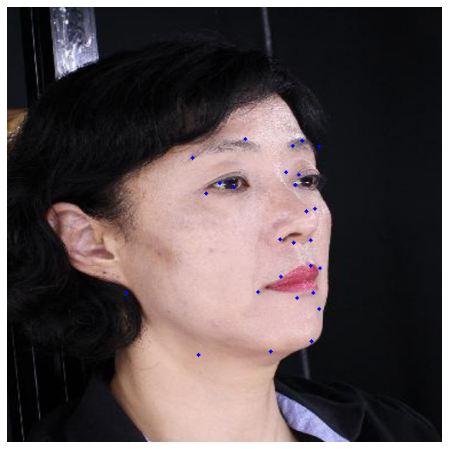

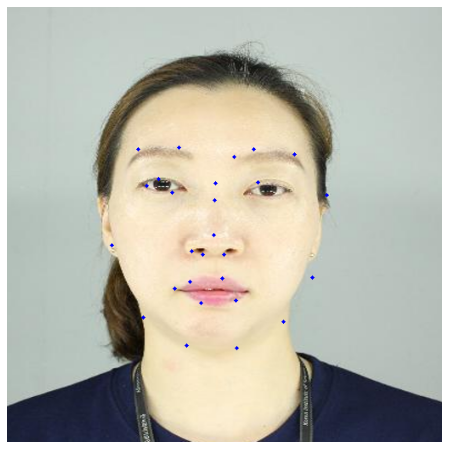

In [4]:
start_time = time.time()

with torch.no_grad():

    for i in range(2):
        num = random.randint(0,len(IMAGE_LIST))
        img_name = Path(IMAGE_LIST[num]).stem
        image = cv2.imread(IMAGE_LIST[num])
        output = inference(image)

        plt.figure(figsize=(8,8))
        result = cv2.cvtColor(output, cv2.COLOR_RGB2BGR)

        plt.axis("off")
        plt.imshow(result, cmap = 'gray')
        # plt.savefig(f"output/{img_name}.png")